In [1]:
import json
import networkx as nx
import matplotlib.pyplot as plt

In [32]:
import os

def list_json_file_paths(directory):
    return [
        os.path.join(directory, f)
        for f in os.listdir(directory)
        if f.endswith('.json') and (not f.startswith('config')) and os.path.isfile(os.path.join(directory, f))
    ]
def build_tree_from_dict(tree_dict, graph=None, parent=None):
    if graph is None:
        graph = nx.DiGraph()
    # Add node with attribute
    response = tree_dict['eva_process'][0]['output'] if len(tree_dict['eva_process']) else ''
    thought_list = tree_dict['eva_process'][0]['thought_list'] if len(tree_dict['eva_process']) else []
    
    graph.add_node(tree_dict['id'], is_true=tree_dict['is_true'], reward=tree_dict['reward'], response=response, thoughts=thought_list)
    # Add edge from parent to current
    if parent is not None:
        graph.add_edge(parent, tree_dict['id'])
    # Recurse for children
    for child in tree_dict.get('children', []):
        build_tree_from_dict(child, graph, tree_dict['id'])
    return graph

all_thoughts = []
for jsn in list_json_file_paths('output/gsm8k/gemma-2-2b/22_034827')[:-1]:
    with open(jsn, 'r') as fin:
        solution = json.load(fin)
    # print(solution)
    G = build_tree_from_dict(solution['tree_lists'])
    temp = [(n, data['is_true'], data['thoughts']) for n, data in G.nodes(data=True) if data['thoughts']!=[]]
    all_thoughts.append(temp)

len(all_thoughts)


99

{'id': 0, 'question': None, 'depth': 0, 'guide_embedding': '[i.tolist() for i in self.guide_embedding] if self.guide_embedding is not None else None', 'standard_answer': None, 'model_answer': None, 'cot_answer': None, 'clean_answer': None, 'is_true': False, 'reward': 0, 'cum_rewards': [0.5, 0.5, 1.0, 1.0, 1.3333333333333333, 1.3333333333333333, 1.3333333333333333, 1.3333333333333333, 0.8333333333333334], 'is_terminal': False, 'eva_process': [{'prompt': 'Based on the given question and the previous answers, please provide your analysis and final answer, starting the final answer with "Answer:"\n\nQuestion:\nIt takes Roque two hours to walk to work and one hour to ride his bike to work. Roque walks to and from work three times a week and rides his bike to and from work twice a week. How many hours in total does he take to get to and from work a week with walking and biking?\n\nYour previous answers:\n0. Thought: 2 hours to walk to work + 2 hours to walk back from work = 4 hours to walk t

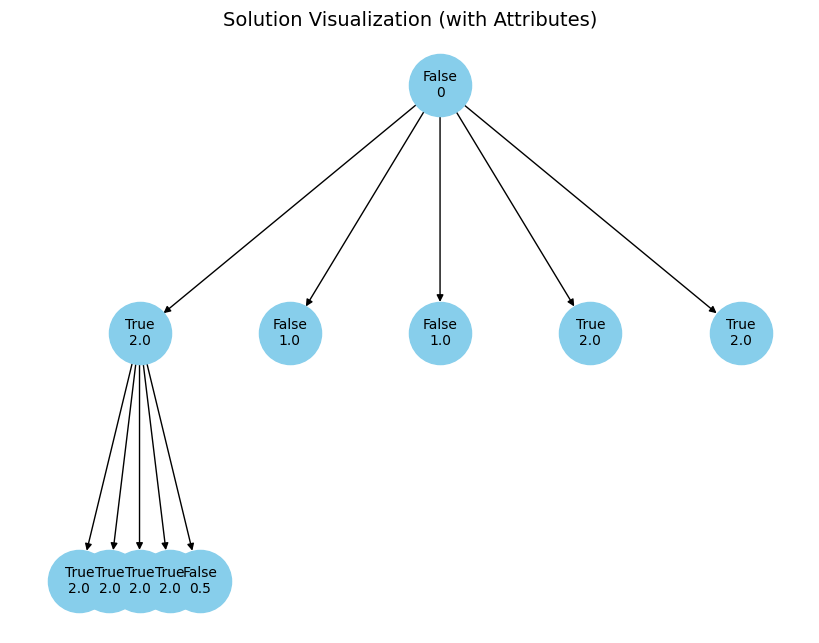

In [4]:
def build_tree_from_dict(tree_dict, graph=None, parent=None):
    if graph is None:
        graph = nx.DiGraph()
    # Add node with attribute
    graph.add_node(tree_dict['id'], is_true=tree_dict['is_true'], reward=tree_dict['reward'])
    # Add edge from parent to current
    if parent is not None:
        graph.add_edge(parent, tree_dict['id'])
    # Recurse for children
    for child in tree_dict.get('children', []):
        build_tree_from_dict(child, graph, tree_dict['id'])
    return graph


def hierarchy_pos(G, root=None, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5):
    if not nx.is_tree(G):
        raise TypeError("cannot use hierarchy_pos on a graph that is not a tree")

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = [n for n, d in G.in_degree() if d == 0][0]
        else:
            root = list(G.nodes)[0]

    def _hierarchy_pos(G, root, leftmost, width, vert_gap, vert_loc, xcenter,
                       pos=None, parent=None, parsed=[]):
        if pos is None:
            pos = {root: (xcenter, vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.successors(root))
        if len(children) != 0:
            dx = width / len(children)
            nextx = xcenter - width / 2 - dx / 2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G, child, leftmost, dx, vert_gap, vert_loc - vert_gap,
                                     nextx, pos, root, parsed)
        return pos

    return _hierarchy_pos(G, root, 0, width, vert_gap, vert_loc, xcenter)

with open('output/gsm8k/gemma-2-2b/22_034827/90.json', 'r') as fin:
    solution = json.load(fin)
print(solution['tree_lists'])
# Build graph
G = build_tree_from_dict(solution['tree_lists'])
print(G)
# Get hierarchical positions
pos = hierarchy_pos(G, root=0)
print(G.nodes(data=True))
labels = {n: f"{data['is_true']}\n{round(data['reward'], 2)}"
          for n, data in G.nodes(data=True)}

# Draw
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=False, node_size=2000, node_color="skyblue", arrows=True)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)
plt.title("Solution Visualization (with Attributes)", fontsize=14)
plt.show()
